<a href="https://colab.research.google.com/github/terrysu64/Machine-Learning-and-Data-Science-Projects/blob/main/convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional neural networks + computer vision

In [ ]:
#get data

import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2022-07-29 15:21:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  47.5MB/s    in 2.2s    

2022-07-29 15:21:56 (47.5 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



### inspect data

In [ ]:
!ls pizza_steak

test  train


In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(dirpath, len(dirnames), len(filenames))

pizza_steak 2 0
pizza_steak/test 2 0
pizza_steak/test/steak 0 250
pizza_steak/test/pizza 0 250
pizza_steak/train 2 0
pizza_steak/train/steak 0 750
pizza_steak/train/pizza 0 750


In [ ]:
#get classnames
import pathlib 
import numpy as np

data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['pizza', 'steak'], dtype='<U5')

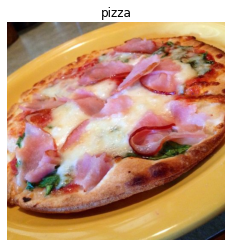

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import random

def view_rand_img(target_dir, target_class):
  folder = target_dir+target_class
  rand_img = random.sample(os.listdir(folder), 1)
  img = mpimg.imread(folder + "/" + rand_img[0])

  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  return img.shape

img=view_rand_img("pizza_steak/train/", "pizza")

## end-to-end example

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG #batches of tensor image data with real-time data augmentation.

tf.random.set_seed(42)

#preprocess data
train_datagen = IDG(rescale=1./225,
                    rotation_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True)
valid_datagen = IDG(rescale=1./225)

#paths
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

#import data and turn to batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(225,225),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(225,225),
                                               class_mode="binary",
                                               seed=42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation="relu",
                         input_shape=(225, 225, 3)),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2,
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data)
                    )

Epoch 1/5
47/47 [==============================] - 37s 472ms/step - loss: 0.5540 - accuracy: 0.7133 - val_loss: 0.5300 - val_accuracy: 0.7400
Epoch 2/5
47/47 [==============================] - 22s 467ms/step - loss: 0.4610 - accuracy: 0.7847 - val_loss: 0.3426 - val_accuracy: 0.8600
Epoch 3/5
47/47 [==============================] - 23s 499ms/step - loss: 0.4280 - accuracy: 0.8173 - val_loss: 0.3682 - val_accuracy: 0.8280
Epoch 4/5
47/47 [==============================] - 22s 468ms/step - loss: 0.4191 - accuracy: 0.8213 - val_loss: 0.3111 - val_accuracy: 0.8760
Epoch 5/5
47/47 [==============================] - 22s 473ms/step - loss: 0.4025 - accuracy: 0.8233 - val_loss: 0.3590 - val_accuracy: 0.8580


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 221, 221, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

## model debrief

In [ ]:
img,labels = train_data.next()
len(img), len(labels)

(32, 32)

In [ ]:
#kernels -> slide over image, larger kernal learn large features and vice-versa
#padding -> pads the target tensors with zeros, usually used for gathering more information from edges
#stride -> determines how much input information is compressed when kernel moves

#resource: https://poloclub.github.io/cnn-explainer/

#if theres disparity between train and validation sets, overfitting can be reduced by:
# a) Max Pooling (condenses image so only most important features are learned)
# b) data augmentation
#

### visualize augmented image

Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 224.5, 224.5, -0.5)

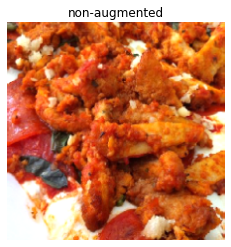

In [ ]:
#augmented

augmented_datagen = IDG(rescale=1./225, 
                        rotation_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)

augmented_data = augmented_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(225,225),
                                               class_mode="binary",
                                               seed=42,
                                               shuffle=False)

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(225,225),
                                               class_mode="binary",
                                               seed=42,
                                               shuffle=False)

img,labels = train_data.next()

img_a,labels_a = augmented_data.next()

from random import randint
i = randint(0,32)
plt.title('non-augmented')
plt.imshow(img[i])
plt.axis(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 224.5, 224.5, -0.5)

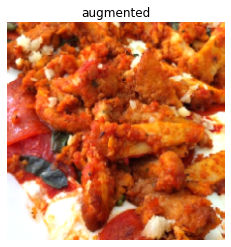

In [ ]:
plt.title('augmented')
plt.imshow(img_a[i])
plt.axis(False)

### using custom image

(-0.5, 1023.5, 682.5, -0.5)

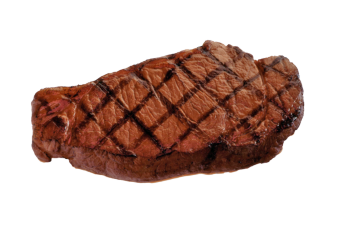

In [ ]:
import matplotlib.image as mpimg

img = mpimg.imread("https://pngimg.com/uploads/steak/steak_PNG29.png")
plt.imshow(img)
plt.axis(False)

In [ ]:
img.shape

(683, 1024, 4)

## Multiclass classification

### inspect data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2022-07-29 15:24:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  80.6MB/s    in 6.6s    

2022-07-29 15:24:41 (74.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(dirpath, len(dirnames), len(filenames))

10_food_classes_all_data 2 0
10_food_classes_all_data/test 10 0
10_food_classes_all_data/test/chicken_curry 0 250
10_food_classes_all_data/test/ramen 0 250
10_food_classes_all_data/test/fried_rice 0 250
10_food_classes_all_data/test/steak 0 250
10_food_classes_all_data/test/grilled_salmon 0 250
10_food_classes_all_data/test/hamburger 0 250
10_food_classes_all_data/test/chicken_wings 0 250
10_food_classes_all_data/test/pizza 0 250
10_food_classes_all_data/test/ice_cream 0 250
10_food_classes_all_data/test/sushi 0 250
10_food_classes_all_data/train 10 0
10_food_classes_all_data/train/chicken_curry 0 750
10_food_classes_all_data/train/ramen 0 750
10_food_classes_all_data/train/fried_rice 0 750
10_food_classes_all_data/train/steak 0 750
10_food_classes_all_data/train/grilled_salmon 0 750
10_food_classes_all_data/train/hamburger 0 750
10_food_classes_all_data/train/chicken_wings 0 750
10_food_classes_all_data/train/pizza 0 750
10_food_classes_all_data/train/ice_cream 0 750
10_food_classes_a

In [ ]:
data_dir = pathlib.Path("10_food_classes_all_data/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

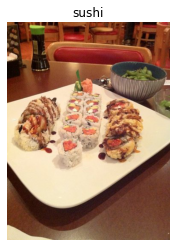

In [ ]:
shape = view_rand_img("10_food_classes_all_data/train/",random.choice(class_names))

In [ ]:
shape

(512, 382, 3)

In [ ]:
#preprocess data
train_datagen = IDG(rescale=1./225,
                    rotation_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True)

valid_datagen = IDG(rescale=1./225)

#paths
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

#import data and turn to batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(225,225),
                                               class_mode="categorical",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(225,225),
                                               class_mode="categorical",
                                               seed=42)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(10, 3, activation="relu", input_shape=(225, 225, 3)),
  tf.keras.layers.Conv2D(10, 3, activation="relu", input_shape=(225, 225, 3)),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history = model.fit(train_data,
                    epochs=2,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data)
                    )

Epoch 1/2
235/235 [==============================] - 112s 473ms/step - loss: 2.1631 - accuracy: 0.2024 - val_loss: 2.0548 - val_accuracy: 0.2468
Epoch 2/2
235/235 [==============================] - 118s 501ms/step - loss: 2.0104 - accuracy: 0.2859 - val_loss: 1.9390 - val_accuracy: 0.3048


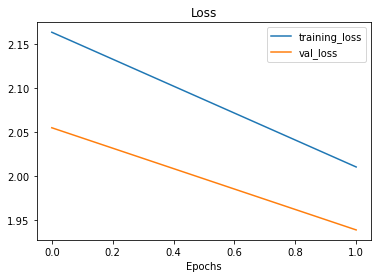

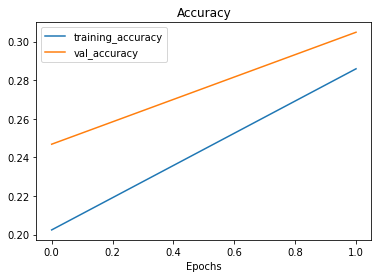

In [ ]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history) #more epochs are likely required

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 223, 223, 10)      280       
                                                                 
 conv2d_13 (Conv2D)          (None, 221, 221, 10)      910       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_15 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

### making predictions

In [40]:
!wget https://static.onecms.io/wp-content/uploads/sites/9/2021/03/10/spicy-chicken-curry-FT-RECIPE0321.jpg

--2022-07-29 16:00:22--  https://static.onecms.io/wp-content/uploads/sites/9/2021/03/10/spicy-chicken-curry-FT-RECIPE0321.jpg
Resolving static.onecms.io (static.onecms.io)... 13.224.250.51, 13.224.250.29, 13.224.250.86, ...
Connecting to static.onecms.io (static.onecms.io)|13.224.250.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 724885 (708K) [image/jpeg]
Saving to: ‘spicy-chicken-curry-FT-RECIPE0321.jpg’

spicy-chicken-curry 100%[===================>] 707.90K  --.-KB/s    in 0.007s  

2022-07-29 16:00:23 (105 MB/s) - ‘spicy-chicken-curry-FT-RECIPE0321.jpg’ saved [724885/724885]



In [57]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=225):
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.
  return img

def pred_and_plot(model, filename, class_names):
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[max([i for i in range(len(pred[0]))], key=lambda i:pred[0][i])] #could by multiclass or binary
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

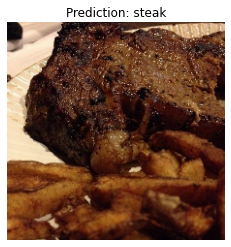

In [65]:
pred_and_plot(model,"/content/pizza_steak/test/steak/1012080.jpg",class_names)

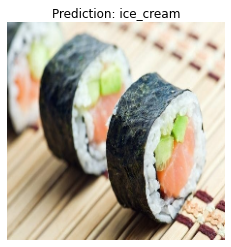

In [66]:
pred_and_plot(model,"/content/myfitnesspal-dos-and-donts-of-sushi.jpeg",class_names)